In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly.graph_objs as go
%matplotlib inline

In [10]:
# Import et aperçu des datasets
df_2024_Table = pd.read_excel("C:/Users/annel/OneDrive/Documents/1_Formation_Datascientest/Projet_final/Git-Analyse_du_bien_etre/DataForTable2.1.xls")
df_continents = pd.read_csv("C:/Users/annel/OneDrive/Documents/1_Formation_Datascientest/Projet_final/Git-Analyse_du_bien_etre/continents2.csv")

display(df_2024_Table.head())
display(df_continents.head())

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195
1,Afghanistan,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092
2,Afghanistan,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324
3,Afghanistan,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,0.267175
4,Afghanistan,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,0.267919


,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [11]:
# Correspondance des noms de pays
df_2024_Table['Country name'] = df_2024_Table['Country name'].replace({'Türkiye':'Turkey',
                                                                       'Taiwan Province of China':'Taiwan',
                                                                       'Hong Kong S.A.R. of China':'Hong Kong'
                                                                       })

df_continents['name'] = df_continents['name'].replace({'Bosnia And Herzegovina':'Bosnia and Herzegovina',
                                                       'Congo (Democratic Republic Of The)':'Congo (Brazzaville)',
                                                       'Congo':'Congo (Kinshasa)',
                                                       "Côte D'Ivoire":'Ivory Coast',
                                                       'Czech Republic':'Czechia',
                                                       'Macedonia':'North Macedonia',
                                                       'Palestine, State of':'State of Palestine'
                                                       })

# Merge des 2 datasets
df_2024 = pd.merge(df_2024_Table, df_continents[['name', 'region','sub-region']], left_on = "Country name", right_on = "name", how = 'left')

# Drop colonne "name"
df_2024.drop(columns='name', inplace=True)

# Ordre et casse des colonnes
df_2024 = df_2024[['Country name', 'region', 'sub-region'] + [col for col in df_2024.columns if col not in ['Country name', 'region', 'sub-region']]]

df_2024 = df_2024.rename(columns={'region': 'Region', 'sub-region': 'Sub region', 'year': 'Year'})

# Ajout données Kosovo
df_2024.loc[df_2024['Country name'] == 'Kosovo', ['Region', 'Sub region']] = ['Europe', 'Southern Europe']

# Conservation des 10 dernières années 
df_2024 = df_2024.drop(df_2024[df_2024.Year < 2014].index)

In [12]:
correlation = df_2024['Log GDP per capita'].corr(df_2024['Healthy life expectancy at birth'])
print(f"Corrélation entre Log GDP per capita et Healthy life expectancy at birth : {correlation}")

Corrélation entre Log GDP per capita et Healthy life expectancy at birth : 0.8465198812644049


In [18]:
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Nuage de points
fig = px.scatter(df_2024, x='Log GDP per capita', y='Healthy life expectancy at birth',
                 title='Relation entre Log PIB par habitant et Espérance de vie en bonne santé',
                 labels={'Log GDP per capita': 'Log PIB par habitant', 'Healthy life expectancy at birth': 'Espérance de vie en bonne santé'},
                 hover_name='Country name', trendline='ols')  # OLS pour la ligne de tendance
fig.show()


In [14]:
import numpy as np

# Vérifier les valeurs manquantes
print(df_2024[['Log GDP per capita', 'Healthy life expectancy at birth']].isna().sum())

# Vérifier les valeurs infinies
print(np.isinf(df_2024[['Log GDP per capita', 'Healthy life expectancy at birth']]).sum())

# Supprimer les lignes avec des NaN ou des valeurs infinies
df_2024_clean = df_2024.replace([np.inf, -np.inf], np.nan).dropna(subset=['Log GDP per capita', 'Healthy life expectancy at birth'])

# Refaire le modèle de régression avec les données nettoyées
X_clean = sm.add_constant(df_2024_clean['Log GDP per capita'])
y_clean = df_2024_clean['Healthy life expectancy at birth']

# Ajustement du modèle OLS
model_clean = sm.OLS(y_clean, X_clean).fit()

# Affichage des résultats
print(model_clean.summary())

# Prédiction pour la ligne de régression
df_2024_clean['pred_Healthy_life_expectancy'] = model_clean.predict(X_clean)

# Graphique avec la ligne de régression
fig = px.scatter(df_2024_clean, x='Log GDP per capita', y='Healthy life expectancy at birth',
                 title='Relation entre Log PIB par habitant et Espérance de vie en bonne santé',
                 labels={'Log GDP per capita': 'Log PIB par habitant', 'Healthy life expectancy at birth': 'Espérance de vie en bonne santé'},
                 hover_name='Country name')

# Ajouter la ligne de régression
fig.add_traces(px.line(df_2024_clean, x='Log GDP per capita', y='pred_Healthy_life_expectancy').data)

fig.show()


Log GDP per capita                  22
Healthy life expectancy at birth    35
dtype: int64
Log GDP per capita                  0
Healthy life expectancy at birth    0
dtype: int64
                                   OLS Regression Results                                   
Dep. Variable:     Healthy life expectancy at birth   R-squared:                       0.717
Model:                                          OLS   Adj. R-squared:                  0.716
Method:                               Least Squares   F-statistic:                     3340.
Date:                              Thu, 29 Aug 2024   Prob (F-statistic):               0.00
Time:                                      17:50:37   Log-Likelihood:                -3446.5
No. Observations:                              1323   AIC:                             6897.
Df Residuals:                                  1321   BIC:                             6907.
Df Model:                                         1                         

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Sélection des features (variables explicatives) et de la cible
X = df_2024_clean[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Perceptions of corruption']]
y = df_2024_clean['Life Ladder']

# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle d'arbre de décision
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Prédictions
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)

# Calcul de l'erreur quadratique moyenne
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Erreur quadratique moyenne - Train: {mse_train}")
print(f"Erreur quadratique moyenne - Test: {mse_test}")


Erreur quadratique moyenne - Train: 0.00021772410374010841
Erreur quadratique moyenne - Test: 0.3556090310611471


In [26]:
# Drop des colonnes  Country name, Region et Sub region
df = df_2024.drop(['Year', 'Country name', 'Region', 'Sub region'], axis = 1)

Préparation des données

In [27]:
from sklearn.model_selection import train_test_split

# Sélection des features et de la target : "Life Ladder"
X = df_2024.drop(columns=['Life Ladder'])  # Toutes les colonnes sauf 'Life Ladder'
y = df_2024['Life Ladder']  # La colonne cible

# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Suppression des colonnes non pertinentes

In [28]:
# Sélection des features numériques uniquement
X = df_2024.select_dtypes(include=['float64', 'int64'])  # On ne garde que les colonnes numériques
y = df_2024['Life Ladder']  # La colonne cible

# Ou bien encoder les variables catégorielles

from sklearn.preprocessing import LabelEncoder

# On applique l'encodage sur les colonnes catégorielles si nécessaire
for col in df_2024.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_2024[col] = le.fit_transform(df_2024[col])

# On réessaye de diviser les données et de modéliser
X = df_2024.drop(columns=['Life Ladder'])  # Toutes les colonnes sauf 'Life Ladder'
y = df_2024['Life Ladder']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Explication :
<br>
<p>
Encodage des variables catégorielles : on utilise le LabelEncoder pour transformer les colonnes non numériques (comme les pays, les régions) en valeurs numériques.
<br>
Sélection des colonnes numériques : Si on ne veut pas encoder les colonnes catégorielles, on peut choisir de sélectionner uniquement les colonnes numériques pour l'entraînement.
</p>

In [30]:
from sklearn.impute import KNNImputer
import numpy as np

# Création de l'imputer KNN
imputer = KNNImputer(n_neighbors=5)

# Imputation des valeurs manquantes dans X
X_imputed = imputer.fit_transform(X)

# Conversion en DataFrame pour conserver les étiquettes des colonnes
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# Maintenant, réessayez de diviser les données et de modéliser
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)


Explication :
<br>
<p>
KNN Imputer : Cette technique remplace les valeurs manquantes en utilisant la moyenne des n voisins les plus proches pour chaque point manquant, en fonction des autres valeurs numériques de la matrice.
fit_transform : Applique l'imputation sur les données et remplace les valeurs manquantes.
</p>

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Modèle de régression linéaire
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Prédictions
y_pred_lr = lr_model.predict(X_test)

# Évaluation
print("Linear Regression - R2 Score:", r2_score(y_test, y_pred_lr))
print("RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))


Linear Regression - R2 Score: 0.7866304471378855
RMSE: 0.5015759902398027
MAE: 0.38139510847819263


c:\Users\annel\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Implémentation des modèles<br>
<p>Régression linéaire</p>

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Modèle de régression linéaire
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Prédictions
y_pred_lr = lr_model.predict(X_test)

# Évaluation
print("Linear Regression - R2 Score:", r2_score(y_test, y_pred_lr))
print("RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))


Linear Regression - R2 Score: 0.7866304471378855
RMSE: 0.5015759902398027
MAE: 0.38139510847819263


c:\Users\annel\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

# Modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test)

# Évaluation
print("Random Forest - R2 Score:", r2_score(y_test, y_pred_rf))
print("RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))


Random Forest - R2 Score: 0.8926065546639935
RMSE: 0.3558438000198274
MAE: 0.2641387822639567


c:\Users\annel\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



XGBoost

In [37]:
%pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 435.7 kB/s eta 0:04:47
   ---------------------------------------- 0.0/124.9 MB 326.8 kB/s eta 0:06:23
   ---------------------------------------- 0.1/124.9 MB 521.8 kB/s eta 0:04:00
   ---------------------------------------- 0.2/124.9 MB 706.2 kB/s eta 0:02:57
   ---------------------------------------- 0.2/124.9 MB 915.1 kB/s eta 0:02:17
   ---------------------------------------- 0.4/124.9 MB 1.2 MB/s eta 0:01:41
   ---------------------------------------- 0.5/124.9 MB 1.4 MB/s eta 0:01:27
   ---------------------------------------- 0.7/124.9 MB 1.9 MB/s eta 0:01:06
   ---------------------------------------- 1.0/124.9 MB 2.4 MB/s eta 0:00:53
   ---------------------------------------- 1.1/124.9 MB 2.5 MB/s eta 0:00:50
    --------------------------------------- 1.6/124.9 MB 3.1 MB/s et

In [38]:
import xgboost as xgb

# Modèle XGBoost
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, seed=42)
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation
print("XGBoost - R2 Score:", r2_score(y_test, y_pred_xgb))
print("RMSE:", mean_squared_error(y_test, y_pred_xgb, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))


XGBoost - R2 Score: 0.8845521827366944
RMSE: 0.36894648643381067
MAE: 0.27241758861495563


c:\Users\annel\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Explication :
<br>
<p>
plot_importance : Cette fonction affiche un graphique montrant l'importance des différentes caractéristiques utilisées par XGBoost. L'importance peut être mesurée de plusieurs façons (weight, gain, cover).
max_num_features=10 : Limite l'affichage aux 10 caractéristiques les plus importantes pour une meilleure lisibilité.
</p>

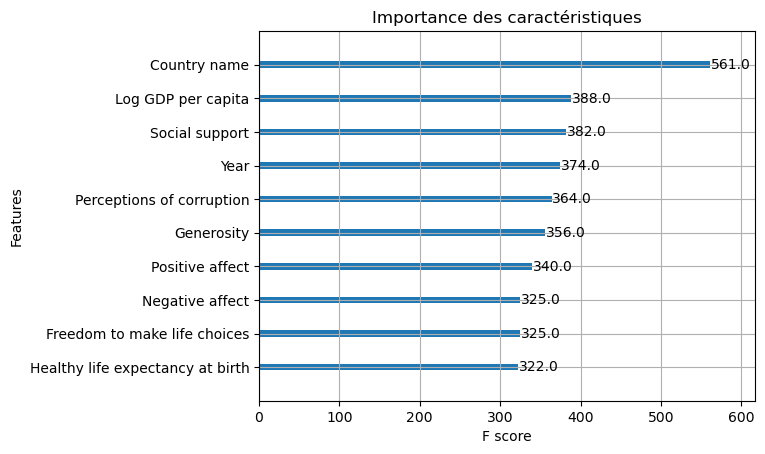

In [39]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Entraînement du modèle XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
xgb_model.fit(X_train, y_train)

# Tracer l'importance des caractéristiques
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title("Importance des caractéristiques")
plt.show()


Explication : <br>
<strong>plot_importance : </strong>Cette fonction affiche un graphique montrant l'importance des différentes caractéristiques utilisées par XGBoost. L'importance peut être mesurée de plusieurs façons (weight, gain, cover).<br>
<strong>max_num_features=10 :</strong> Limite l'affichage aux 10 caractéristiques les plus importantes pour une meilleure lisibilité.

Graphique de la fonction d'erreur

Graphique de la fonction d'erreur : Pour observer l'évolution de l'erreur au cours des itérations <br> permet de voir si le modèle s'améliore et s'il risque de surapprendre (overfitting).

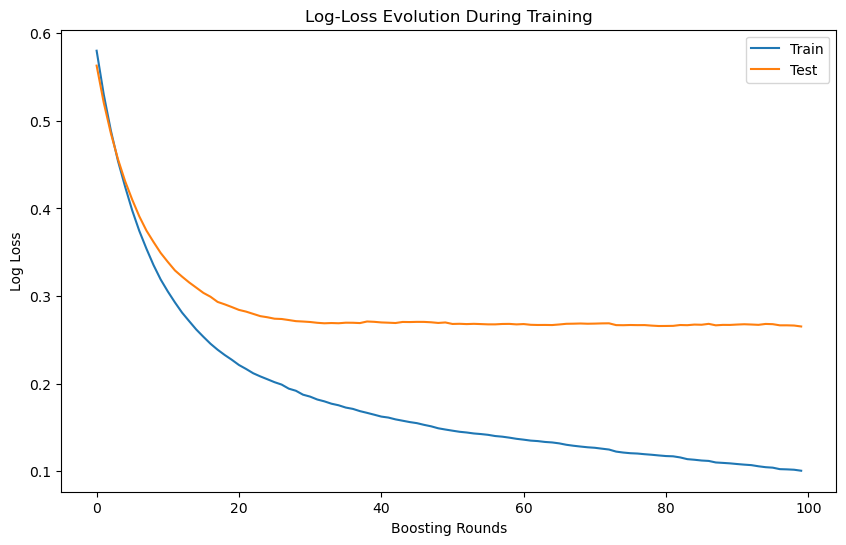

In [44]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Conversion en classification binaire (1 si score >= 5, sinon 0)
y_train_bin = np.where(y_train >= 5, 1, 0)
y_test_bin = np.where(y_test >= 5, 1, 0)

# Conversion en DMatrix pour suivi des performances
dtrain = xgb.DMatrix(X_train, label=y_train_bin)
dtest = xgb.DMatrix(X_test, label=y_test_bin)

# Paramètres du modèle
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',  # Mesure d'erreur utilisée (log-loss pour la classification binaire)
    'learning_rate': 0.1,
    'max_depth': 3,
    'seed': 42
}

# Suivi des performances sur l'ensemble d'entraînement et de test
evals = [(dtrain, 'train'), (dtest, 'eval')]

# Entraînement du modèle avec suivi des performances
evals_result = {}  # Dictionnaire pour stocker les résultats d'évaluation

xgb_model = xgb.train(params, dtrain, num_boost_round=100, evals=evals, evals_result=evals_result, verbose_eval=False)

# Tracé de la fonction d'erreur (log-loss)
epochs = len(evals_result['train']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['train']['logloss'], label='Train')
plt.plot(x_axis, evals_result['eval']['logloss'], label='Test')
plt.legend()
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Log-Loss Evolution During Training')
plt.show()


Explication :
<br>
<p>
<strong>xgb.DMatrix :</strong> Utilisé pour préparer les données pour XGBoost avec évaluation.
<br>
<strong>eval_metric='logloss' :</strong> La métrique d'erreur utilisée pour le modèle de classification binaire (log-loss). BN. On peut aussi choisir d'autres métriques, comme 'auc' pour suivre l'aire sous la courbe ROC.
<br>
<strong>evals_result :</strong> Un dictionnaire pour stocker les résultats de l'évaluation à chaque itération pour l'ensemble d'entraînement et de test.
<br>
<strong>Visualisation : </strong>Le graphique montre l'évolution de la log-loss au fil des itérations de boosting, ce qui permet de voir si le modèle s'améliore et s'il risque de surapprendre (overfitting).
</p>

Interprétation :<br>
Si la courbe d'erreur sur l'ensemble de test diverge de celle de l'entraînement, cela peut indiquer un surapprentissage (overfitting). <br>
Si les deux courbes descendent constamment, cela montre que le modèle s'améliore au fil des itérations.

PCA

1.Standardisation des données
<br>
2. Calcul des composantes principales
<br>
3. Visualisation

1.Standardisation des données

In [47]:
# Vérifier les colonnes contenant des NaN
missing_data = df_2024.isnull().sum()
print(missing_data[missing_data > 0])

Log GDP per capita                  22
Social support                       5
Healthy life expectancy at birth    35
Freedom to make life choices        20
Generosity                          30
Perceptions of corruption           77
Positive affect                     10
Negative affect                      9
dtype: int64


In [53]:
# Supprimer les lignes avec des NaN
df_2024_clean = df_2024.dropna()

# Sélectionner les colonnes numériques après suppression
X_pca_clean = df_2024_clean.select_dtypes(include=['float64', 'int64']).drop(columns=['Life Ladder'])


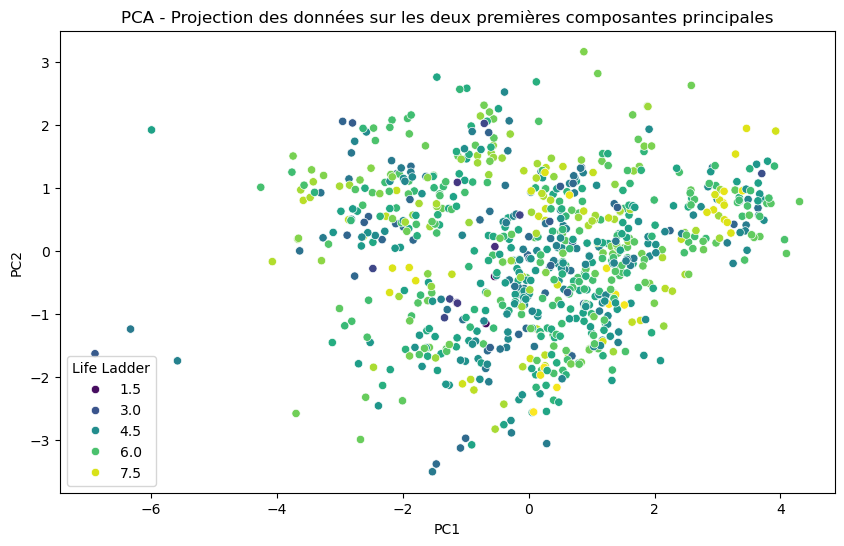

In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#On selectionne les colonnes numériques pour la PCA
X_pca = df_2024.select_dtypes(include=['float64', 'int64']).drop(columns=['Life Ladder'])

# Définir l'imputer pour gérer les valeurs manquantes
imputer = SimpleImputer(strategy='mean')  # Utilisation de la moyenne pour imputer

# Définir le scaler et le PCA
scaler = StandardScaler()
pca = PCA(n_components=2)

#On crée un pipeline avec imputation, standardisation et PCA
pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('pca', pca)
])

#On applique le pipeline aux données
X_pca_reduced = pipeline.fit_transform(X_pca)

# On crée un DataFrame avec les deux premières composantes principales
df_pca = pd.DataFrame(data=X_pca_reduced, columns=['PC1', 'PC2'])

# On ajoute des labels (classes cibles) pour la visualisation
df_pca['Life Ladder'] = y

# Visualisation des deux premières composantes principales avec la variable cible
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Life Ladder', palette='viridis', data=df_pca)
plt.title('PCA - Projection des données sur les deux premières composantes principales')
plt.show()


Points Clés :
<br>
<p>
Imputation : Gère les valeurs manquantes en les remplaçant par la moyenne de la colonne.
<br>
Pipeline : Assure que l'imputation, la standardisation et la PCA sont appliquées dans l'ordre.
<br>
Visualisation : Reste inchangée mais fonctionne maintenant avec les données prétraitées.
</p>

PCA après le traitement des valeurs manquantes

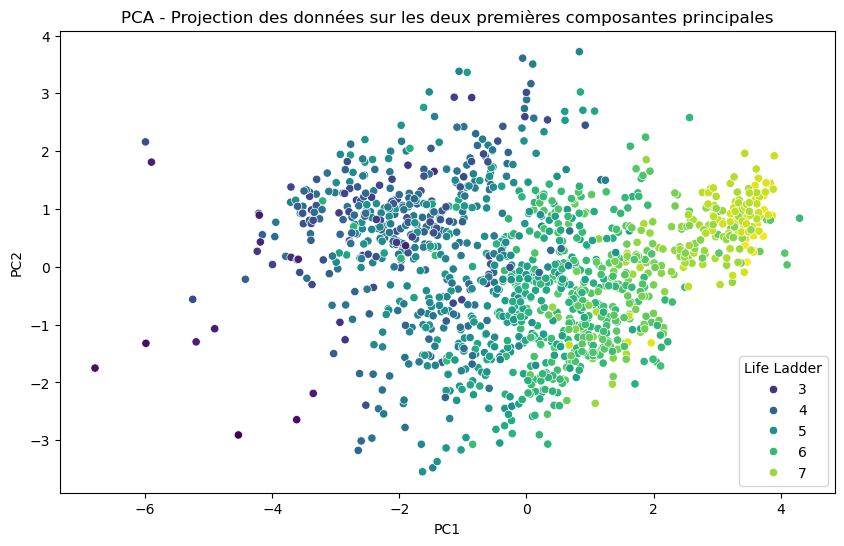

In [60]:
# Standardisation des données après imputation ou suppression des NaN
scaler = StandardScaler()
X_scaled_clean = scaler.fit_transform(X_pca_clean)

# PCA sur les données propres
pca = PCA(n_components=2)
X_pca_reduced = pca.fit_transform(X_scaled_clean)

# Visualisation des deux premières composantes principales
df_pca_clean = pd.DataFrame(data=X_pca_reduced, columns=['PC1', 'PC2'])
df_pca_clean['Life Ladder'] = df_2024_clean['Life Ladder'].values

# Graphique de PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Life Ladder', palette='viridis', data=df_pca_clean)
plt.title('PCA - Projection des données sur les deux premières composantes principales')
plt.show()


Valeurs manquantes

In [63]:
print(X_pca.shape)

(1374, 9)


In [66]:
print(pd.DataFrame(X_scaled).isnull().sum())

0     0
1    22
2     5
3    35
4    20
5    30
6    77
7    10
8     9
dtype: int64


In [68]:
print("Valeurs uniques dans y :", pd.Series(y).unique())


Valeurs uniques dans y : [3.13089561 3.9828546  4.22016859 ... 3.15457821 3.29621959 3.57238626]


In [69]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [71]:
print("Valeurs uniques dans y_train :", pd.Series(y_train).unique())

Valeurs uniques dans y_train : [5.61000347 6.17800999 5.46270037 6.06503868 7.49280357 6.00763607
 5.86056805 6.61380672 4.93213272 4.73295307 5.9458518  6.94893646
 5.38733196 4.76359463 4.63347387 5.92888212 5.99075079 4.6395483
 6.83012533 4.20563459 4.80808258 4.00051689 4.92053127 3.6024549
 4.04226017 3.80820489 6.17148542 7.03757715 6.12801027 6.43144703
 5.74882317 7.44792557 6.0620513  5.07571936 7.29003239 4.03119707
 5.64685249 5.25219297 5.84768391 5.87205505 3.34712124 5.67839527
 6.43622065 7.2946043  6.99761868 6.00423717 6.24941921 5.10412502
 6.03053713 4.22384644 6.48372984 3.41686296 4.65273094 4.93067837
 4.63743639 4.81243658 5.05572605 6.82417297 5.46401548 4.39063358
 6.2722683  5.86581564 4.62396908 3.66059732 3.27209187 5.18568945
 5.96517801 4.3961277  5.54850817 5.25222683 5.60520267 2.37509179
 5.56290531 5.86555243 4.30568314 4.65570259 4.34831953 6.4272213
 6.15734196 4.21054792 5.59427023 6.01552248 7.55778265 4.21329927
 5.87018919 4.49337721 5.93889523 

Vérification des Valeurs Uniques

In [78]:
print("Valeurs uniques dans y_train :", pd.Series(y_train).unique())
print("Valeurs uniques dans y_test :", pd.Series(y_test).unique())

Valeurs uniques dans y_train : [5.61000347 6.17800999 5.46270037 6.06503868 7.49280357 6.00763607
 5.86056805 6.61380672 4.93213272 4.73295307 5.9458518  6.94893646
 5.38733196 4.76359463 4.63347387 5.92888212 5.99075079 4.6395483
 6.83012533 4.20563459 4.80808258 4.00051689 4.92053127 3.6024549
 4.04226017 3.80820489 6.17148542 7.03757715 6.12801027 6.43144703
 5.74882317 7.44792557 6.0620513  5.07571936 7.29003239 4.03119707
 5.64685249 5.25219297 5.84768391 5.87205505 3.34712124 5.67839527
 6.43622065 7.2946043  6.99761868 6.00423717 6.24941921 5.10412502
 6.03053713 4.22384644 6.48372984 3.41686296 4.65273094 4.93067837
 4.63743639 4.81243658 5.05572605 6.82417297 5.46401548 4.39063358
 6.2722683  5.86581564 4.62396908 3.66059732 3.27209187 5.18568945
 5.96517801 4.3961277  5.54850817 5.25222683 5.60520267 2.37509179
 5.56290531 5.86555243 4.30568314 4.65570259 4.34831953 6.4272213
 6.15734196 4.21054792 5.59427023 6.01552248 7.55778265 4.21329927
 5.87018919 4.49337721 5.93889523 

Classes sont Correctement Encodées ?

In [79]:
print("Type de y_encoded :", type(y_encoded))
print("Valeurs uniques dans y_encoded :", pd.Series(y_encoded).unique())

Type de y_encoded : <class 'pandas.core.series.Series'>
Valeurs uniques dans y_encoded : [3.13089561 3.9828546  4.22016859 ... 3.15457821 3.29621959 3.57238626]


Classes sont Cohérentes ?

In [80]:
from sklearn.preprocessing import LabelEncoder

# Encoder y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Vérifier les valeurs uniques dans les données encodées
print("Valeurs uniques dans y_encoded :", pd.Series(y_encoded).unique())


Valeurs uniques dans y_encoded : [ 22 125 179 ...  23  31  69]


Classes Sont Consistentes ?

In [81]:
# Séparer les données en ensembles d'entraînement et de test
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_reduced, y_encoded, test_size=0.3, random_state=42)

# Vérifier les valeurs uniques dans y_train et y_test
print("Valeurs uniques dans y_train :", pd.Series(y_train).unique())
print("Valeurs uniques dans y_test :", pd.Series(y_test).unique())


Valeurs uniques dans y_train : [ 701  962  645  911 1338  882  787 1137  430  357  840 1219  618  368
  327  829  871  332 1190  174  379  128  424   75  144  102  959 1245
  935 1066  742 1331  909  478 1296  139  710  557  782  798   36  720
 1069 1298 1232  877  990  497  898  181 1095   44  336  429  330  380
  468 1186  646  232 1002  794  325   85   30  535  859  235  675  558
  699    4  680  793  205  338  221 1064  951  175  694  891 1351  177
  797  277  837 1308  171 1274    8  130  700  949 1110  395  312   66
  939  153 1347  230  472  861  606  122  841  864  993 1068  800 1014
 1082  482 1143 1020 1044   53  796  149  985  133  726  361 1023 1155
  285  211 1305 1084  776 1267  185  918  179    5 1358  276  802  392
  303 1105  100  173 1284  580  475  689  219  406  544  806 1294 1197
  894 1241 1033  213  485 1235  669  528  711  621  615  916  464  928
 1162  732  364   76  109 1365   93 1297  770  581  555  540  707   65
  527  631  262   80  716 1146 1272  650 1282 

In [84]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd

# On selectionne les colonnes numériques pour la PCA
X_pca = df_2024.select_dtypes(include=['float64', 'int64']).drop(columns=['Life Ladder'])

# On défini l'imputer pour gérer les valeurs manquantes
imputer = SimpleImputer(strategy='mean')  # Utilisation de la moyenne pour imputer

# Standardisation des données
scaler = StandardScaler()

# Définir la PCA
pca = PCA(n_components=9)  # Choisissez une valeur <= nombre de caractéristiques

# ajout d'un pipeline avec imputation, standardisation et PCA
pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('pca', pca)
])

# On applique le pipeline aux données
X_pca_reduced = pipeline.fit_transform(X_pca)

# Encoder y si c'est nécessaire
if not pd.api.types.is_numeric_dtype(y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
else:
    y_encoded = y

# on vérifie les valeurs uniques dans y_encoded
print("Valeurs uniques dans y_encoded :", pd.Series(y_encoded).unique())

# on doit séparer les données en ensembles d'entraînement et de test
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_reduced, y_encoded, test_size=0.3, random_state=42)

# on vérifie les valeurs uniques dans y_train et y_test
print("Valeurs uniques dans y_train :", pd.Series(y_train).unique())
print("Valeurs uniques dans y_test :", pd.Series(y_test).unique())

# on crée et entraîner le modèle
xgb_clf = xgb.XGBClassifier()  # Exemple avec XGBoost
xgb_clf.fit(X_train_pca, y_train)

# Évaluer le modèle ùais optionnelle
print("Score du modèle sur les données de test :", xgb_clf.score(X_test_pca, y_test))


Valeurs uniques dans y_encoded : [3.13089561 3.9828546  4.22016859 ... 3.15457821 3.29621959 3.57238626]
Valeurs uniques dans y_train : [5.61000347 6.17800999 5.46270037 6.06503868 7.49280357 6.00763607
 5.86056805 6.61380672 4.93213272 4.73295307 5.9458518  6.94893646
 5.38733196 4.76359463 4.63347387 5.92888212 5.99075079 4.6395483
 6.83012533 4.20563459 4.80808258 4.00051689 4.92053127 3.6024549
 4.04226017 3.80820489 6.17148542 7.03757715 6.12801027 6.43144703
 5.74882317 7.44792557 6.0620513  5.07571936 7.29003239 4.03119707
 5.64685249 5.25219297 5.84768391 5.87205505 3.34712124 5.67839527
 6.43622065 7.2946043  6.99761868 6.00423717 6.24941921 5.10412502
 6.03053713 4.22384644 6.48372984 3.41686296 4.65273094 4.93067837
 4.63743639 4.81243658 5.05572605 6.82417297 5.46401548 4.39063358
 6.2722683  5.86581564 4.62396908 3.66059732 3.27209187 5.18568945
 5.96517801 4.3961277  5.54850817 5.25222683 5.60520267 2.37509179
 5.56290531 5.86555243 4.30568314 4.65570259 4.34831953 6.4272

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575
 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719
 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737
 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755
 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773
 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791
 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809
 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827
 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845
 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863
 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881
 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899
 900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917
 918 919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935
 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953
 954 955 956 957 958 959 960], got [1.2812711  1.44590855 2.1788094  2.35242772 2.37509179 2.43603444
 2.63375258 2.66171813 2.69352317 2.69430327 2.70159125 2.8166225
 2.88811231 2.90273428 2.98267388 3.05751395 3.08215499 3.13089561
 3.15457821 3.18616247 3.20719671 3.24876976 3.27209187 3.29621959
 3.30679655 3.33164787 3.33463359 3.34712124 3.35230017 3.35467601
 3.38339758 3.40753222 3.4124825  3.41686296 3.4450233  3.4473815
 3.46018291 3.4613657  3.47108483 3.47586203 3.47649264 3.4813478
 3.483109   3.48327851 3.49893665 3.50488114 3.53157353 3.54520369
 3.55825377 3.5610466  3.56976247 3.57238626 3.58790827 3.58805633
 3.59037852 3.59251404 3.59567833 3.6024549  3.60285473 3.6158452
 3.62466431 3.62807155 3.63528323 3.63830018 3.64015484 3.66059732
 3.67145371 3.67562699 3.68056798 3.70319128 3.71429443 3.72809839
 3.7619648  3.76830196 3.76991916 3.7752831  3.79483795 3.79530072
 3.80820489 3.81806874 3.82386565 3.83199239 3.8691237  3.88064027
 3.88330555 3.88877845 3.90274167 3.91807318 3.92266417 3.92934418
 3.92981625 3.96454287 3.96795797 3.97281957 3.97471428 3.9828546
 3.98486018 3.98591614 4.00051689 4.0073576  4.01913404 4.02289486
 4.02421951 4.02574778 4.02869034 4.02935028 4.03119707 4.03654385
 4.04111481 4.04202843 4.04226017 4.04611111 4.05601263 4.07058668
 4.07862043 4.08956242 4.09264851 4.09955502 4.10344696 4.11309576
 4.11354876 4.11949348 4.12194061 4.12331867 4.12434292 4.13485289
 4.15261936 4.16216469 4.1794939  4.18094349 4.18445063 4.19085455
 4.19691277 4.20563459 4.21054792 4.21156502 4.21329927 4.21732569
 4.22016859 4.22134542 4.22384644 4.22386551 4.23464584 4.23768663
 4.24044132 4.25028086 4.25079918 4.26086807 4.26947355 4.27986336
 4.28773642 4.2920332  4.2920475  4.2978487  4.29845142 4.30568314
 4.30977106 4.31403971 4.31547976 4.32171488 4.32267523 4.32547188
 4.32783175 4.33094549 4.33908749 4.34583712 4.34831953 4.35761786
 4.35906982 4.36663961 4.36997604 4.37698507 4.37795067 4.37926245
 4.39063358 4.39611483 4.3961277  4.4125371  4.41429996 4.41572952
 4.41983414 4.42437935 4.42449093 4.42469549 4.43136406 4.43300056
 4.43423748 4.43502378 4.43843985 4.44794655 4.44838619 4.45077467
 4.45101023 4.45254803 4.45308304 4.46125937 4.46220779 4.46239901
 4.46454096 4.46651888 4.47214937 4.48253727 4.48280525 4.48632526
 4.48651409 4.49120712 4.49337721 4.49343109 4.49391508 4.49948597
 4.49997044 4.50133133 4.50514126 4.51110077 4.51365519 4.51441145
 4.52145338 4.54409552 4.54658413 4.5493145  4.5539217  4.55514145
 4.5561409  4.55674076 4.55893707 4.57141924 4.57315493 4.57382965
 4.5739913  4.57628155 4.58584213 4.59453392 4.59609318 4.60861635
 4.60865784 4.61567354 4.61885023 4.62060165 4.62230015 4.62311983
 4.62396908 4.62813282 4.63347387 4.63550854 4.6355648  4.63743639
 4.63893366 4.6395483  4.64090967 4.64689112 4.65273094 4.6537137
 4.65570259 4.65909719 4.66101265 4.6619091  4.66794109 4.67244482
 4.6760087  4.69076347 4.69523907 4.72193813 4.73081112 4.73295307
 4.73967743 4.74113226 4.74185038 4.74995565 4.75623703 4.75677347
 4.76359463 4.76768446 4.76937723 4.76973963 4.78238297 4.78300905
 4.78516531 4.78624725 4.78781414 4.80261755 4.80808258 4.81243658
 4.81376314 4.82319498 4.82717991 4.8284564  4.83176422 4.83408785
 4.83756065 4.84316444 4.85118532 4.85318089 4.856534   4.86540127
 4.86893749 4.87372255 4.88399124 4.88507271 4.8864007  4.88654995
 4.88732576 4.89615774 4.89679193 4.9028306  4.90457964 4.90537596
 4.90661812 4.90681982 4.91008663 4.92053127 4.92723608 4.93067837
 4.93213272 4.93673754 4.93857813 4.94453955 4.94680071 4.94896269
 4.95372963 4.96165657 4.96274757 4.96680975 4.97216845 4.9763608
 4.97699547 4.98799181 4.99437904 4.99531794 4.99828482 5.00037527
 5.00428057 5.00440264 5.00614595 5.01548529 5.03796482 5.04279995
 5.04308605 5.05366421 5.05532169 5.05572605 5.05675173 5.06186247
 5.0622673  5.0624485  5.07075071 5.07405138 5.07542229 5.07571936
 5.0763154  5.07958508 5.08086634 5.08212852 5.08492327 5.0899024
 5.09272528 5.09690189 5.09840155 5.09953976 5.10372114 5.10412502
 5.10755301 5.10843801 5.1127286  5.1142168  5.11717796 5.11864185
 5.12203121 5.1231432  5.12492132 5.12691164 5.13143396 5.13632536
 5.13950062 5.14412022 5.14677477 5.14824152 5.15398979 5.16315699
 5.16362715 5.16400719 5.16688156 5.16718674 5.16799545 5.16840982
 5.17197132 5.17338943 5.17527866 5.17591524 5.17789936 5.18086529
 5.18568945 5.19561911 5.19757462 5.20543814 5.21221304 5.21262264
 5.21389484 5.21701765 5.21956778 5.22914886 5.23302555 5.23869848
 5.23983479 5.24891233 5.2489543  5.25073767 5.25219297 5.25222683
 5.25548172 5.25650358 5.26967573 5.27072382 5.27128458 5.28272057
 5.28439093 5.28682423 5.28995848 5.29534149 5.29738331 5.303895
 5.30406618 5.31053877 5.31248283 5.31255007 5.31948328 5.32155085
 5.32495594 5.32553053 5.32622194 5.32624865 5.33022213 5.33302164
 5.33385038 5.3388176  5.34085369 5.34438324 5.35063505 5.35446167
 5.36247492 5.36490965 5.37339878 5.37834883 5.38069248 5.38194275
 5.38602495 5.38630724 5.38733196 5.39201212 5.40302467 5.40459347
 5.40928936 5.41687536 5.42169333 5.4279542  5.43083286 5.43358326
 5.43487215 5.43775511 5.44052362 5.4446907  5.44663715 5.44826126
 5.44890165 5.45805073 5.46234179 5.46270037 5.46401548 5.46462297
 5.4674511  5.4715538  5.47417593 5.47429991 5.47537184 5.48873663
 5.49021435 5.49746895 5.49842072 5.50294828 5.51350021 5.51446533
 5.51581621 5.51841593 5.52827263 5.53355169 5.53474998 5.5362711
 5.53817225 5.54748917 5.54850817 5.5529151  5.55925894 5.55972433
 5.56290531 5.57726336 5.57778406 5.57874298 5.57962275 5.58103037
 5.5846858  5.59427023 5.59772301 5.59865379 5.60520267 5.60726213
 5.61000347 5.61540461 5.62251902 5.62574387 5.62890863 5.62953663
 5.63809681 5.64685249 5.64777994 5.64815474 5.64967537 5.65018988
 5.65262556 5.66784096 5.67427063 5.67839527 5.67909002 5.67966127
 5.6822772  5.68522072 5.69431782 5.69486952 5.70062876 5.70449924
 5.70917511 5.71093655 5.7113781  5.71149921 5.71890783 5.72216272
 5.72689342 5.72911549 5.74050093 5.74064207 5.74882317 5.7591691
 5.75941229 5.76536322 5.76779222 5.77106476 5.77749109 5.78021145
 5.78737926 5.79146004 5.79269552 5.79357529 5.79606295 5.80132532
 5.80138016 5.81240082 5.81300545 5.81373358 5.81895256 5.82145309
 5.82923412 5.83432913 5.84192991 5.84768391 5.85175371 5.85988617
 5.86056805 5.86118317 5.86479855 5.86481237 5.86555243 5.86581564
 5.86810207 5.86917257 5.87018919 5.87205505 5.87968445 5.88174057
 5.88454437 5.88713217 5.88975906 5.89206886 5.90056705 5.90115404
 5.90281677 5.90440416 5.90827894 5.90950918 5.91011572 5.91067648
 5.91573429 5.91705847 5.91982269 5.9241128  5.92888212 5.93005133
 5.93566608 5.93577099 5.9364934  5.93682146 5.93889523 5.94225025
 5.9458518  5.94719458 5.94899225 5.95001364 5.9521575  5.95564651
 5.95837879 5.96407509 5.964221   5.96505785 5.96517801 5.96887064
 5.96975374 5.97028875 5.97056437 5.97236443 5.97781754 5.97806883
 5.97938204 5.98241043 5.99075079 5.99316311 5.99496031 5.99553871
 5.99938154 6.00025988 6.00423717 6.00627947 6.00763607 6.01039171
 6.01273966 6.01419878 6.01530027 6.01552248 6.01623869 6.01849604
 6.02215147 6.03053713 6.03348064 6.03697681 6.0380497  6.04154634
 6.04407263 6.04800653 6.0620513  6.06503868 6.0855608  6.08595514
 6.08990479 6.0910821  6.09130239 6.09132481 6.09534883 6.09547329
 6.10421419 6.111485   6.11191893 6.11254501 6.11363602 6.11543751
 6.11763811 6.11796331 6.12801027 6.12994242 6.13761187 6.1388731
 6.13945532 6.14476395 6.14603186 6.14919996 6.15064287 6.15087891
 6.1540494  6.15734196 6.15985346 6.16200447 6.16207647 6.16513395
 6.16683769 6.16826916 6.16967344 6.17148542 6.17317581 6.17411757
 6.17800999 6.18013859 6.18301439 6.19092178 6.19185972 6.19887018
 6.2012682  6.20176268 6.20546007 6.22664785 6.22982025 6.23017311
 6.23371506 6.24116516 6.24140739 6.24209404 6.24342871 6.24511194
 6.24674416 6.24941921 6.2570796  6.25847673 6.25981045 6.26099348
 6.26217508 6.26650858 6.26774502 6.2722683  6.27294064 6.276443
 6.27837801 6.28143406 6.28236437 6.29485464 6.29564476 6.3088789
 6.30923891 6.30968142 6.3186121  6.32011938 6.3251152  6.33292913
 6.33304596 6.33600998 6.33690214 6.34549189 6.35309076 6.35489845
 6.35639334 6.35711432 6.35762501 6.35891628 6.35945082 6.36212492
 6.36349678 6.36550903 6.37171459 6.37452936 6.37456417 6.37481737
 6.37835979 6.38161039 6.38536072 6.39182568 6.39225769 6.39322853
 6.40844822 6.4102993  6.4151988  6.41850376 6.42144775 6.4251442
 6.4272213  6.43144703 6.4356308  6.43622065 6.44101381 6.44541693
 6.45114899 6.45211792 6.45256376 6.45647764 6.45744944 6.45839214
 6.4649868  6.46700478 6.4739213  6.47520876 6.47635651 6.48184681
 6.48372984 6.48835611 6.48858976 6.49215603 6.51285076 6.51337099
 6.5165267  6.52087212 6.53603077 6.53708982 6.54328966 6.54558754
 6.54689693 6.54872561 6.54957867 6.55265427 6.55277872 6.55692148
 6.55958843 6.56144381 6.5676589  6.56839752 6.57905626 6.59084225
 6.60555029 6.60801744 6.61380672 6.61952496 6.62659168 6.63117123
 6.63522243 6.63566399 6.64849949 6.65535164 6.65620661 6.66172171
 6.66626501 6.67085266 6.67111444 6.67566586 6.67983103 6.68465281
 6.68964434 6.70157146 6.71078253 6.7141118  6.72177982 6.72339773
 6.72838402 6.73297739 6.73562717 6.74576855 6.75106764 6.75782919
 6.75814772 6.77213812 6.78514242 6.78956795 6.79249048 6.79817724
 6.80359983 6.82417297 6.8242836  6.82700634 6.83012533 6.83095026
 6.83876085 6.85532904 6.85687447 6.86394691 6.86457253 6.86696196
 6.86986399 6.87779284 6.88175631 6.88268471 6.88384438 6.89112711
 6.89217186 6.89709139 6.90421915 6.90971088 6.92717886 6.93943548
 6.94249678 6.94893646 6.94999981 6.95337391 6.96233559 6.98099899
 6.98546362 6.99761868 7.00573158 7.01606226 7.02490473 7.0346961
 7.03493071 7.03713751 7.03757715 7.0383687  7.03941965 7.07941103
 7.07964087 7.09801245 7.10327339 7.1090765  7.13028431 7.13561773
 7.13670063 7.13736773 7.14107466 7.15111446 7.15715122 7.15901089
 7.16077709 7.17549658 7.19492817 7.19536114 7.22518158 7.22793484
 7.23344517 7.23399496 7.23914766 7.24263096 7.24484587 7.24708605
 7.25479364 7.25484133 7.25703764 7.28680468 7.28855038 7.28892231
 7.29003239 7.29372787 7.2946043  7.30425787 7.30589247 7.31189775
 7.31415129 7.31434107 7.32118845 7.32443714 7.32767248 7.33103609
 7.36874437 7.3747921  7.38406897 7.39600182 7.40401554 7.41277266
 7.41486835 7.41812086 7.43121433 7.43928003 7.44426203 7.44792557
 7.44879436 7.45851994 7.4589653  7.4630971  7.47359324 7.49280357
 7.49807072 7.50419283 7.50444794 7.50843525 7.51003456 7.51463127
 7.53250456 7.54087734 7.55778265 7.56160927 7.56462479 7.57548952
 7.577528   7.59370232 7.66239738 7.69300318 7.69422102 7.69874716
 7.69892931 7.72899818 7.78034782 7.78825188 7.7943778  7.85810709
 7.88934994]